# Регуляризация. Выбор модели. Перебор параметров алгоритма.

# Bias-Variance Decomposition

Bias-Variance decomposition (разложение ошибки на смещение и разброс) - способ представления получаемой алгоритмом ошибки для дальнейшего анализа.

**В чем идея?** Обучение модели $a$ - во многом вероятностный процесс, поэтому и ошибка алгоритма тоже. Она зависит от обучающей выборки ($X$), от тестового объекта ($x$) и от случайного шума (ɛ), поэтому можем представить ошибку модели на конкретном объекте $x$ в виде:

$$ L_a(x) = Bias^2 + Variance + \sigma^2 $$

где:
- $Bias = f(x) - \mathbb{E}_X [a(x, X)]$ - **смещение** предсказания алгоритма в точке $x$, усредненного по всем возможным обучающим выборкам $X$, относительно истинной зависимости $f$
- $Variance = \mathbb{E}_X [a(x, X) - \mathbb{E}_[a(x, X)]] $ - **дисперсия (разброс)** предсказаний алгоритма в точке $x$ в зависимости от обучающей выборки $X$
- $\sigma^2=\mathbb{E}_x \mathbb{E}_\varepsilon[y(x, \varepsilon)-f(x)]^2$ - неустранимый **шум** в данных

Простыми словами - ошибка алгоритма состоит из двух частей:

- **смещение** - насколько хорошо в среднем предсказывает алгоритм
- **разброс** - насколько чувствителен алгоритм к обучающей выборке

Наша модель может иметь разную величину смещения и разброса:

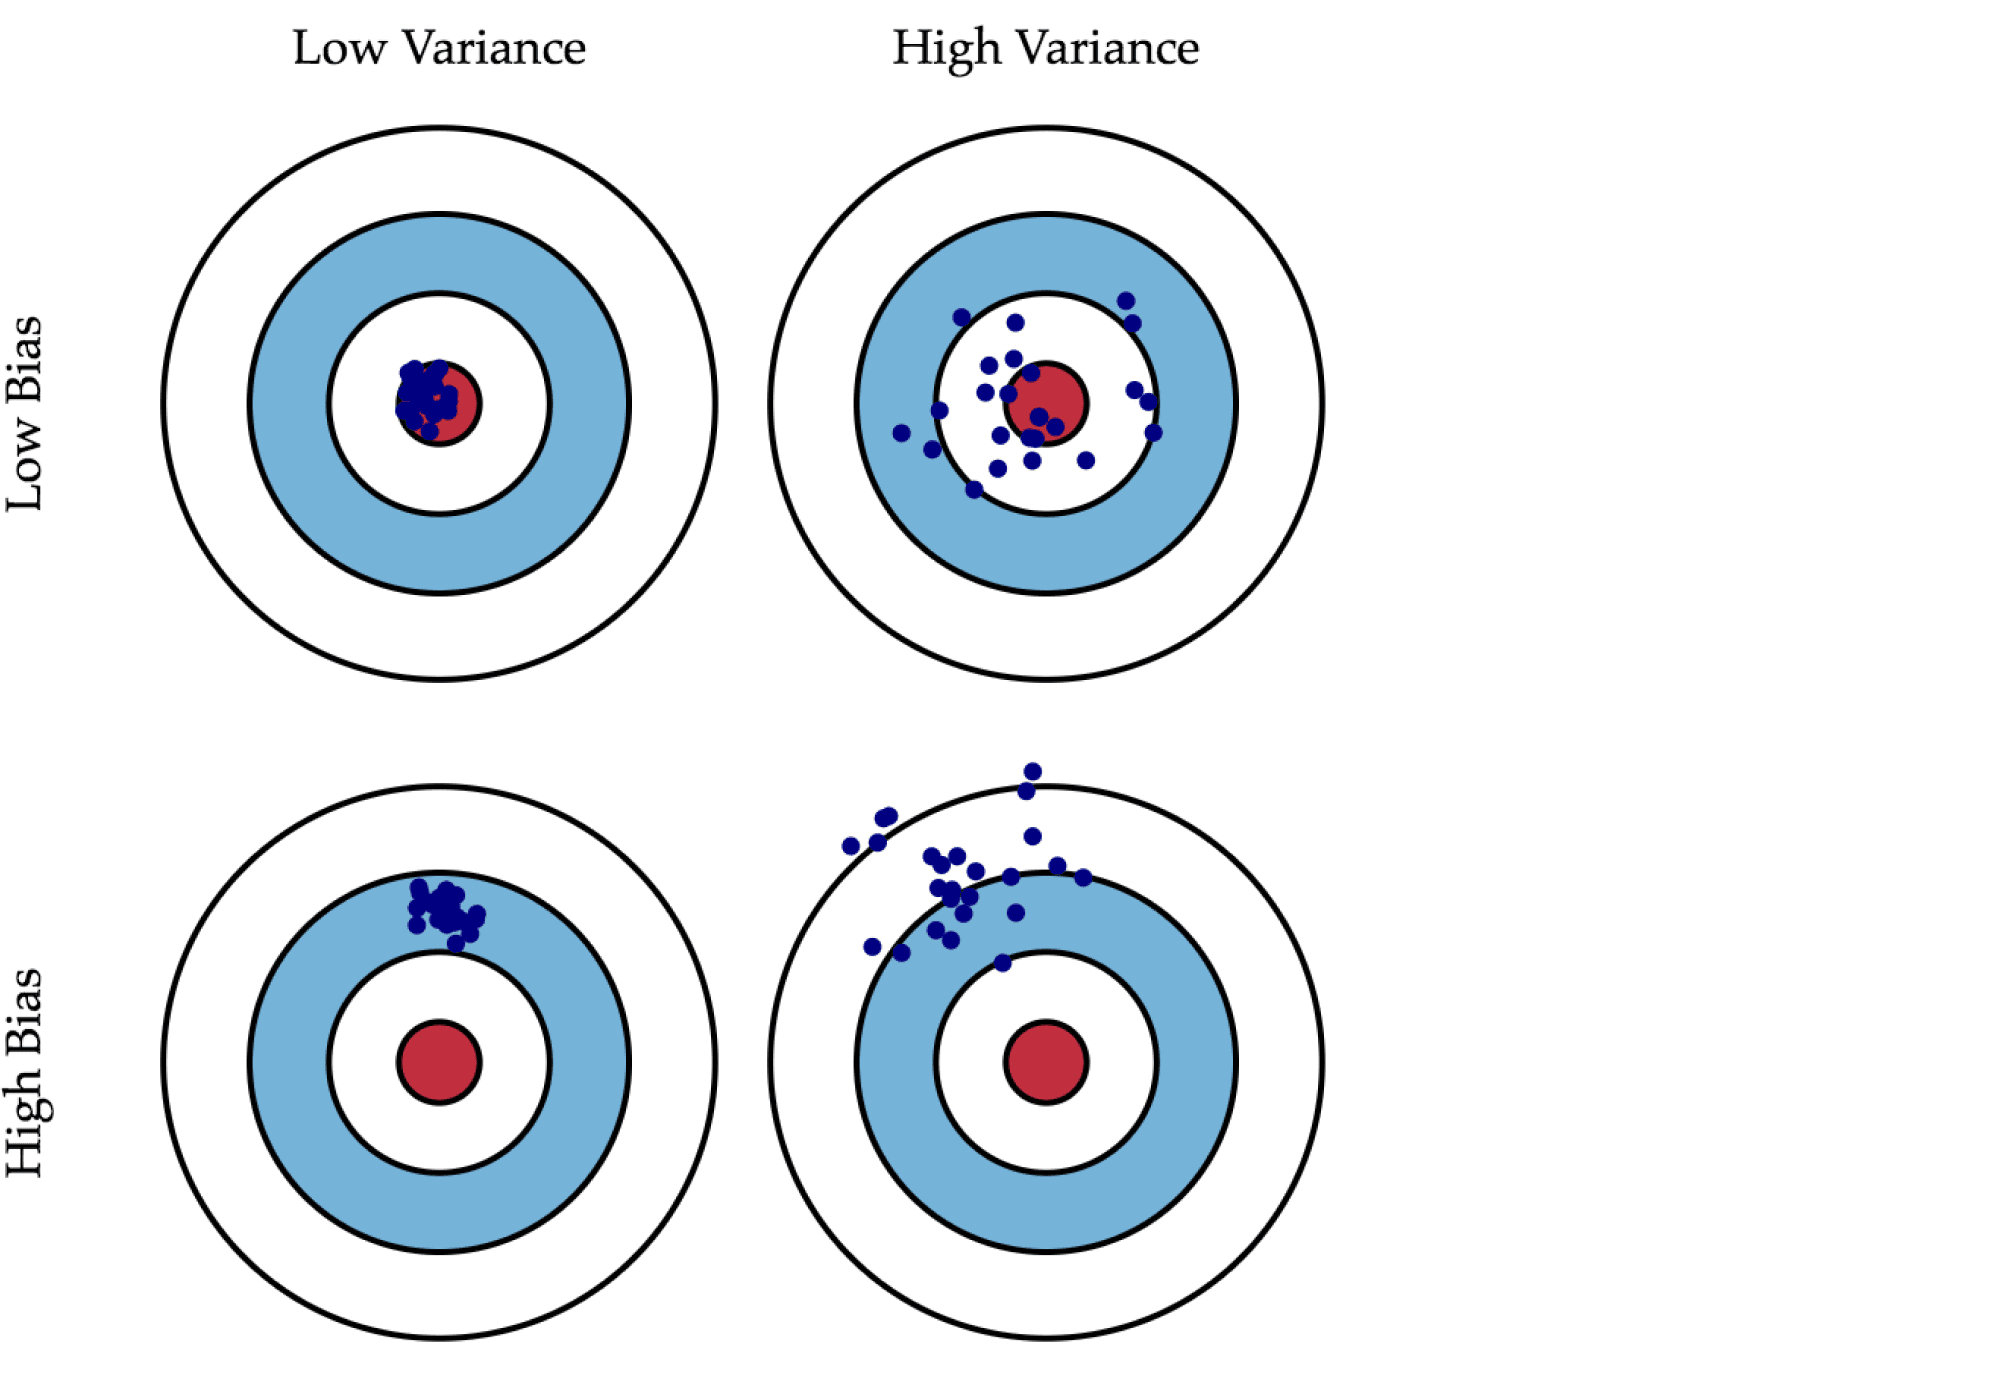

Рисунки выше соответствуют разным моделям:
- High Bias, Low Variance - недообученная модель / слишком простая модель
- Low Bias, High Variance - переобученная модель / слишком сложная модель
- Low Bias, Low Variance - идеальная модель
- High Bias, High Variance - ужасная модель (скорее всего что-то сильно сделали не так)

В идеале хотим получить модель с низким разбросом и низким смещением, но часто приходится находить компромисс (**tradeoff**).

Чаще всего это достигается с помощью увеличения `Bias` за счет уменьшения `Variance`.

В большинстве случаев ситуация выглядит следующим образом:

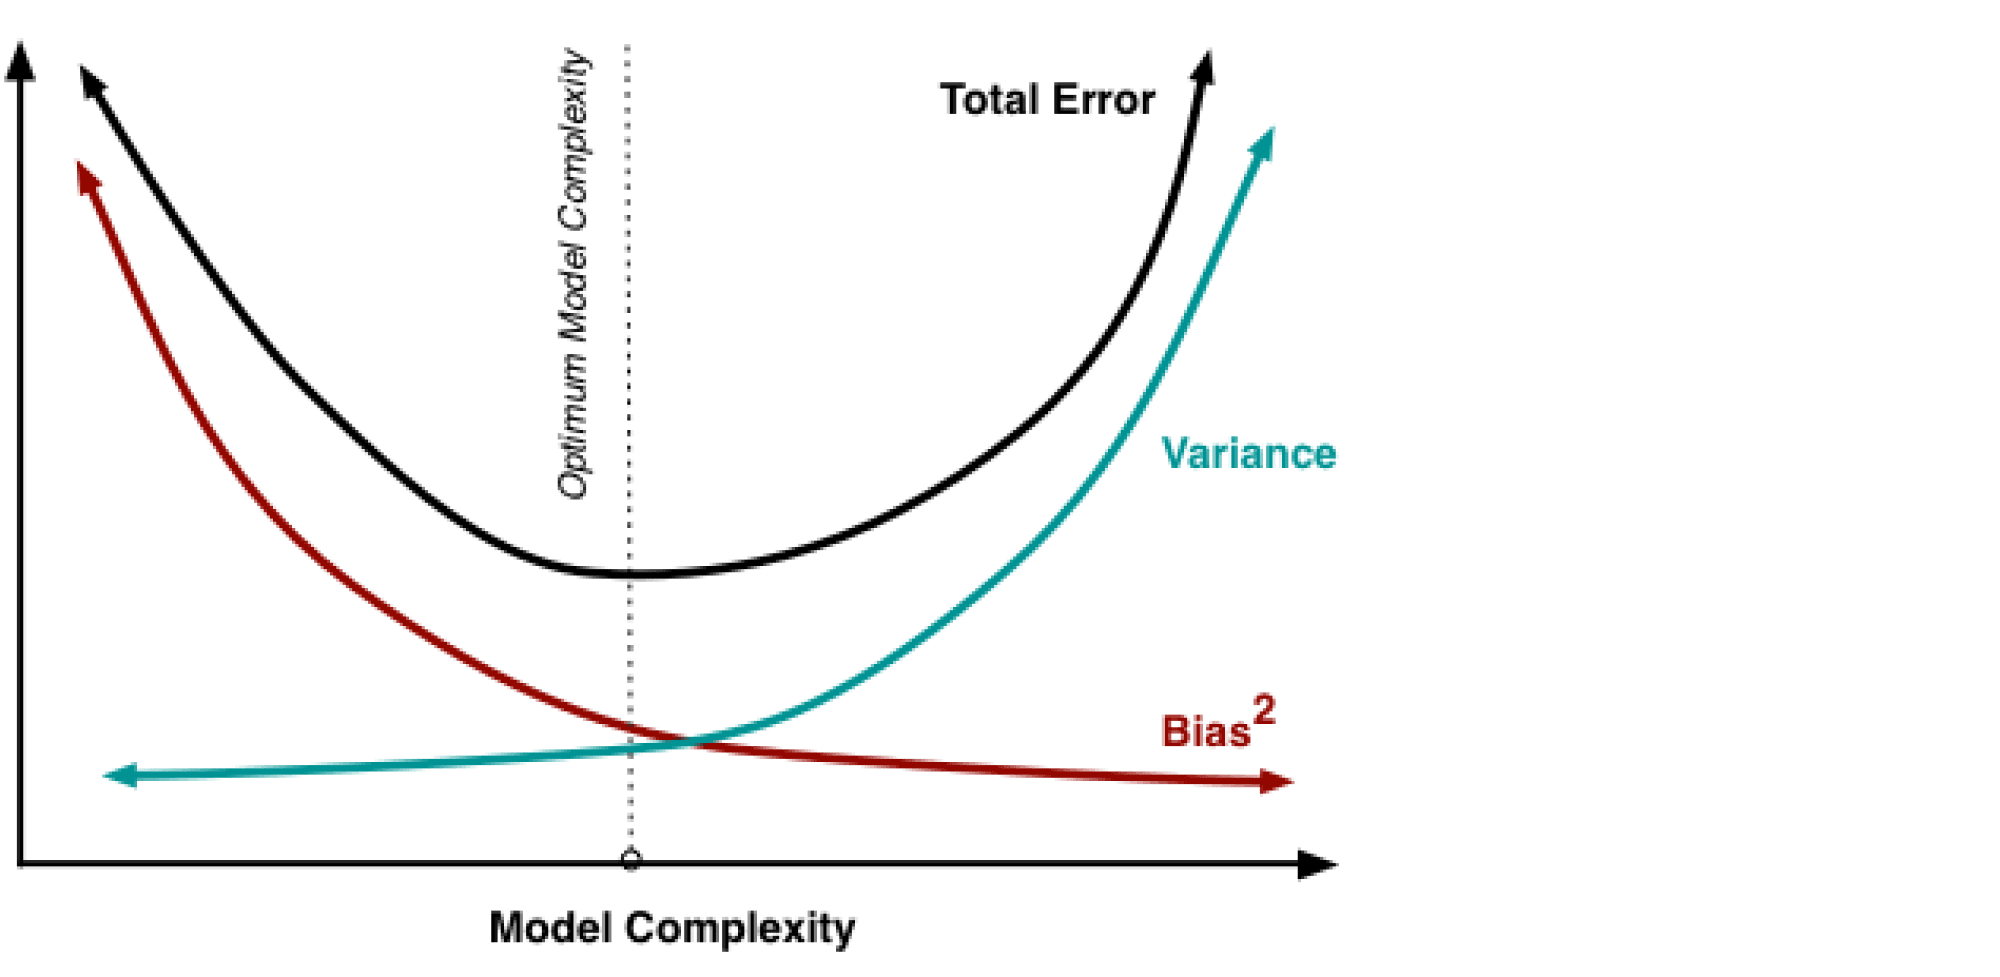

Такая ситуация наблюдается для многих семейств моделей машинного обучения.

В некоторой степени - и для нейросетей, но есть нюанс, обсудим его, когда дойдем до нейросетей.

# Мультиколлинеарность

Чаще в данных мы можем наблюдать так называемую **мультиколлинеарность** — когда два или несколько признаков сильно коррелированы, например, когда в матрице $X$ присутствует "почти" линейной зависимости столбцов.

Например, в задаче прогнозирования цены квартиры по ее параметрам "почти" линейная зависимость будет у признаков "площадь с учетом балкона" и "площадь без учета балкона".

**В чем проблема?** Формально для таких данных матрица $X^T X$ будет обратима, но из-за мультиколлинеарности у матрицы некоторые собственные значения $\lambda_i$ будут близки к нулю, а в обратной матрице $(X^T X)^{-1}$ появятся экстремально большие собственные значения, т.к. собственные значения обратной матрицы – это $\frac{1}{\lambda_i}$.

Проверим это!

Снова сгенерируем наш синусоидный датасет из прошлого занятия:

In [ ]:
import pandas as pd
import numpy as np

def generate_data(n_support=1000, n_train=25, std=0.3):
    data = {}
    # выберем некоторое количество точек из промежутка от 0 до 2*pi
    data['support'] = np.linspace(0, 2*np.pi, num=n_support)
    # для каждой посчитаем значение sin(x) + 1
    # это будет ground truth
    data['values'] = np.sin(data['support']) + 1
    return data


def select_train_data(data, n_train=25, std=0.3):
    # из support посемплируем некоторое количество точек с возвратом, это будут признаки
    data['x_train'] = np.sort(np.random.choice(data['support'], size=n_train, replace=True))
    # опять посчитаем sin(x) + 1 и добавим шум, получим целевую переменную
    data['y_train'] = np.sin(data['x_train']) + 1 + np.random.normal(0, std, size=data['x_train'].shape[0])
    return data


data = generate_data(1000)
data = select_train_data(data, n_train=50, std=0.3)

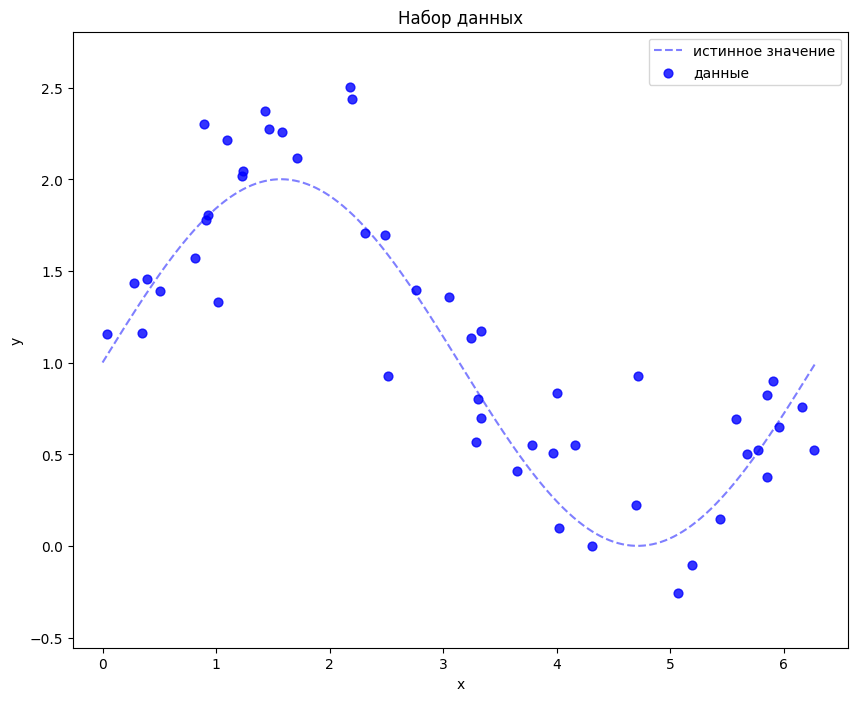

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
margin = 0.3
plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='истинное значение')
plt.scatter(data['x_train'], data['y_train'], 40, 'b', 'o', alpha=0.8, label='данные')
plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)
plt.legend()
plt.title('Набор данных')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Одного признака - мало, давайте перейдем к полиномиальной регрессии! Возьмем степень побольше:

In [ ]:
degree = 13
dlist = [np.ones(data['x_train'].shape[0])] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
X = np.array(dlist).T

In [ ]:
X.shape

(50, 14)

Посмотрим на собственные значения матрицы $X$:

In [ ]:
np.linalg.eigvals(np.cov(X[:, 1:].T))

array([ 2.50357370e+19,  1.04858548e+15,  1.68683426e+11,  1.20381459e+08,
        1.99378302e+05,  7.72195281e+02,  6.95664968e+00, -8.95246182e-01,
        1.96540689e-01,  6.03406981e-03, -7.78899961e-03, -1.41992417e-04,
        5.02391206e-06])

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


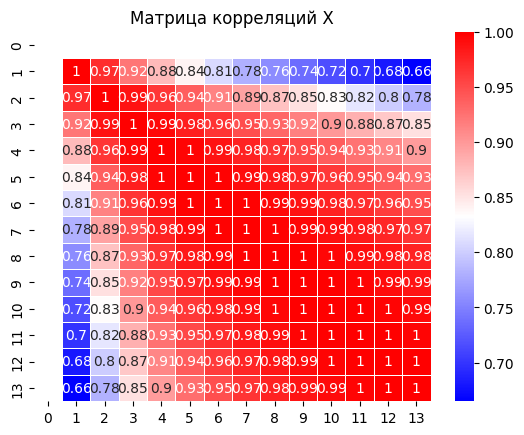

In [ ]:
sns.heatmap(np.corrcoef(X.T), cmap=plt.cm.bwr, annot=True, linewidth=.5)

plt.title('Матрица корреляций X')
plt.show()

Видим, что признаки сильно скоррелированы ($>0.95$ по Пирсону). Из-за этого при нахождении обратной матрицы $(X^TX)^{-1}$ будем получать сильно разные значения в зависимости от конкретной обучающей выборки.

In [ ]:
def check_dispersion(degree):
    data = generate_data(1000)
    data = select_train_data(data, n_train=50, std=0.3)
    w_list = []
    err = []

    plt.figure(figsize=(10, 8)) # устанавливаем размер фигуры
    plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='истинное значение') # отображаем данные с параметрами

    for i in range(10): # проходимся по полиномам и строим модель на новых данных
        # список с предрасчитанными степенями признака
        dlist = [np.ones(data['x_train'].shape[0])] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
        X = np.array(dlist).T
        w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), data['y_train'])
        w_list.append(w)
        y_hat = np.dot(w, X.T)

        plt.plot(data['x_train'], y_hat, label=f'Exp: {i}')
        data = select_train_data(data, n_train=100, std=0.3)
    plt.legend()

    w_arr = np.array(w_list)
    stds = w_arr.std(axis=1)
    print(f"mean={stds.mean()}, std={stds.std()}")
    print(stds)

mean=1.0191528396709928, std=0.05924845702116348
[1.03619748 0.97241511 0.97496558 0.99307103 1.11965318 0.95510737
 1.0345797  1.10337057 0.93859268 1.0635757 ]


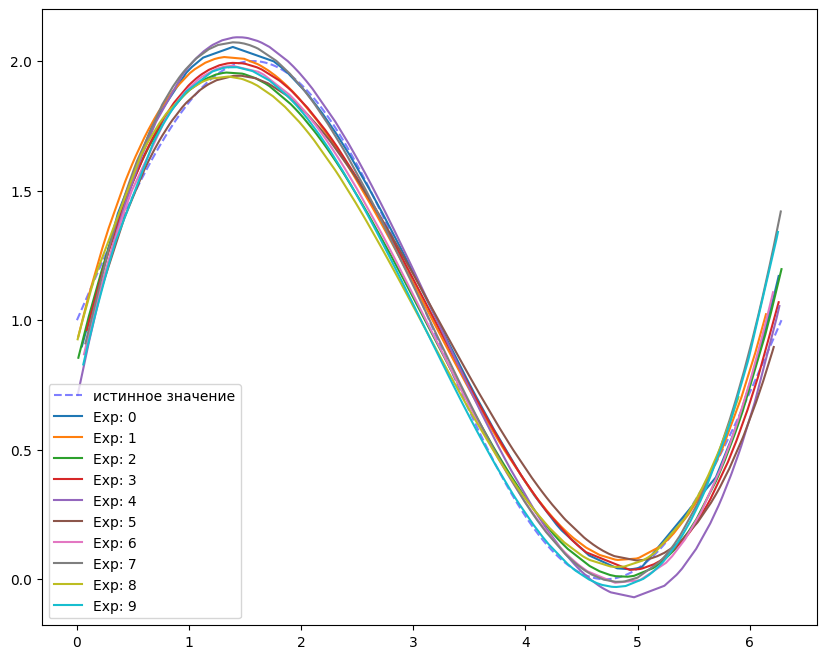

In [ ]:
check_dispersion(degree=3)

mean=1.3748181260931456, std=0.5603408656960137
[1.33592747 2.18161671 2.24951113 1.46953378 0.78894459 0.91095946
 1.15039844 0.46917471 1.90139579 1.29071918]


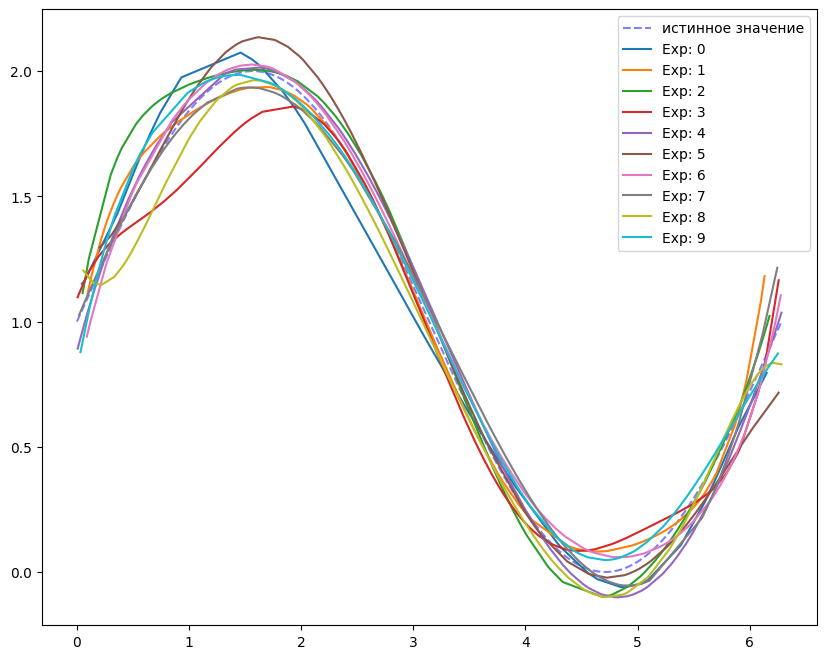

In [ ]:
check_dispersion(degree=7)

mean=41.217296802310685, std=39.53213786724655
[129.53356571   5.86945308  76.40205858  51.84261789   5.32245716
  75.75597366  21.05265375  14.20621263  29.28239943   2.90557614]


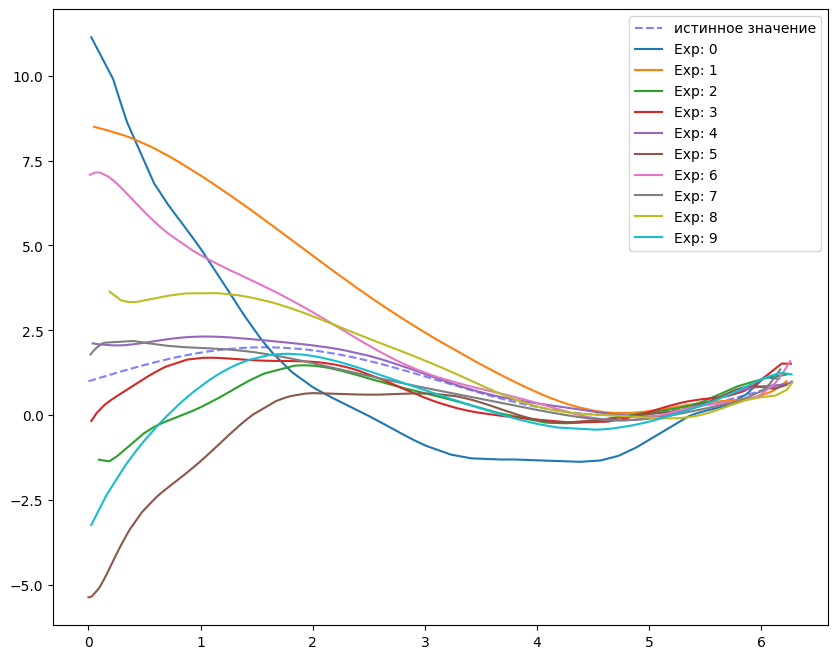

In [ ]:
check_dispersion(degree=13)

Видим, что теперь модель абсолютно неустойчива к обучающей выборке - High Variance!

**Что делать?** Нашу задачу нужно скорректировать, а именно, сделать матрицу $X^TX$ невырожденной, или регулярной - провести процесс **регуляризации**.

# Регуляризация

**Регуляризация** - способ уменьшить сложность модели для предотвращения переобучения или исправить некорректно поставленную задачу.

Признаком плохой обусловленности является наличие у матрицы собственных значений, близких к нулю. Поэтому один из способов решения проблемы - модифицировать матрицу так, чтобы все её собственные значения $\lambda$ увеличились на заданное число, а все собственные векторы сохранились.

С другой стороны, раз мы решаем задачу минимизации функции потерь и одновременно хотим получить не очень большие веса, то давайте добавим в функцию потерь еще одно слагаемое - штраф за веса модели:

$$\Large \mathcal{L}_{reg} \left(X, \vec{y}, \vec{w}\right) = \mathcal{L}\left(X, \vec{y}, \vec{w}\right) + \lambda R\left(\vec{w}\right)$$

где $\lambda$ - коэффициент регуляризации, то, насколько сильно мы хотим учитывать условие $R$.

R, как и исходную функцию потерь, можно задавать по-разному, но, как правило, ничего сложнее, чем $L_1$ и $L_2$-нормы, не требуется.

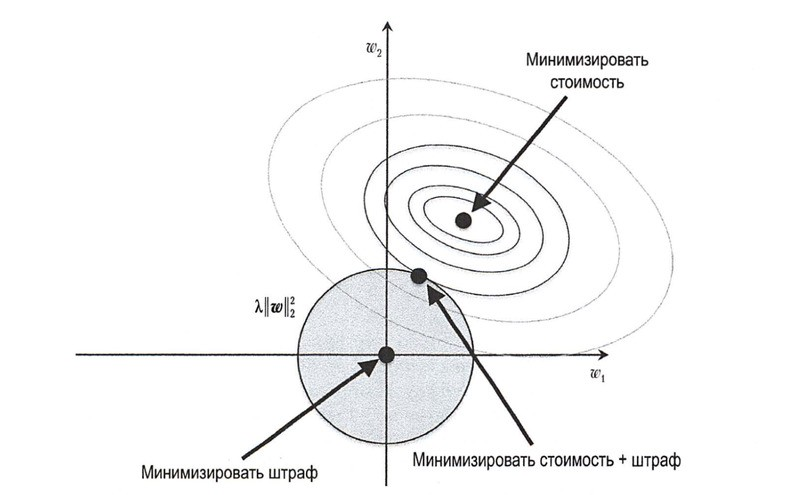

По амплитуде значений значений параметров можно ограничить норму вектора параметров на $L^2$. На изображении показана визуальная интуиция за ограничениями на параметры, накладываемые $w_1$, $w_2$.


## $L_2$-регуляризация

Один из самых простых вариантов - штрафовать за большую норму $L_2$ вектора весов:

$$\large R\left(\vec{w}\right) = \frac{1}{2} \left\| \vec{w} \right\|_2^2 = \frac{1}{2} \sum_{j=1}^m w_j^2 = \frac{1}{2} \vec{w}^T \vec{w}$$

Тогда новая функция потерь будет иметь вид:

$$\large \mathcal{L}\left(X, \vec{y}, \vec{w} \right) = \frac{1}{2} \left(\vec{y} - X \vec{w}\right)^T \left(\vec{y} - X \vec{w}\right) + \frac{\lambda}{2} \vec{w}^T \vec{w}$$

Найдем производную ф-ии потерь по $\large \vec{w}$:

$$\Large\begin{array}{rcl}
\frac{\partial\mathcal{L}}{\partial\vec{w}} &=& \frac{\partial}{\partial\vec{w}}\left( \frac{1}{2} (\vec{y} - X \vec{w})^T (\vec{y} - X \vec{w}) + \frac{\lambda}{2} \vec{w}^T \vec{w} \right) &=& \\
&=& \frac{1}{2} \frac{\partial}{\partial\vec{w}}\left( (\vec{y}^T - \vec{w}^T X^T) (\vec{y} - X \vec{w}) \right) + \lambda \vec{w} &=& \\
&=& \frac{1}{2} \left( \frac{\partial}{\partial\vec{w}}(\vec{y}^T \vec{y}) - \frac{\partial}{\partial\vec{w}}(\vec{y}^T X \vec{w}) - \frac{\partial}{\partial\vec{w}}(\vec{w}^T X^T \vec{y}) + \frac{\partial}{\partial\vec{w}}(\vec{w}^T X^T X \vec{w}) \right) + \lambda \vec{w} &=& \\
&=& \frac{1}{2} \left( 0 - (\vec{y}^T X)^T - X^T\vec{y} + 2X^T X \vec{w} \right) + \lambda \vec{w} &=& \\
&=& -X^T \vec{y} + X^T X \vec{w} + \lambda \vec{w}
\end{array}$$

Приравняв к нулю получим:

$$\large \begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} = 0 &\Leftrightarrow& -X^T \vec{y} + X^T X \vec{w} + \lambda \vec{w} = 0 \\
&\Leftrightarrow& X^T X \vec{w} + \lambda \vec{w} = X^T \vec{y} \\
&\Leftrightarrow& \left(X^T X + \lambda E\right) \vec{w} = X^T \vec{y} \\
&\Leftrightarrow& \vec{w} = \left(X^T X + \lambda E\right)^{-1} X^T \vec{y}
\end{array}$$

Где $E$ - единичная диагональная матрица

По сути - эквивалентно добавлению единичной матрицы с коэффициентом перед обращением матрицы.

Такая регрессия называется **гребневой регрессией** (**ridge** regression). А гребнем является диагональная матрица которая прибавляется к матрице $X^T X$ с линейнозависимыми колонками, в результате получаемая матрица не сингулярна. В таком случае число обусловленности будет отношением собственных чисел

$$\frac{e_{max} + \lambda}{e_{min} + \lambda}$$

Таким образом, увеличивая параметр регуляризации мы уменьшаем число обусловленности, а обусловленность задачи улучшается.

Реализуем $L_2$-регуляризацию на практике и сравним разные полиномиальные регрессии с учетом регуляризации:

Полином 1 mse: 0.25801481203770926
Полином 2 mse: 0.2627854774338079
Полином 3 mse: 0.10811582384341394
Полином 5 mse: 0.08571413999875921
Полином 7 mse: 0.08567651571094116
Полином 10 mse: 0.07504773037331693
Полином 13 mse: 0.07882424580889456


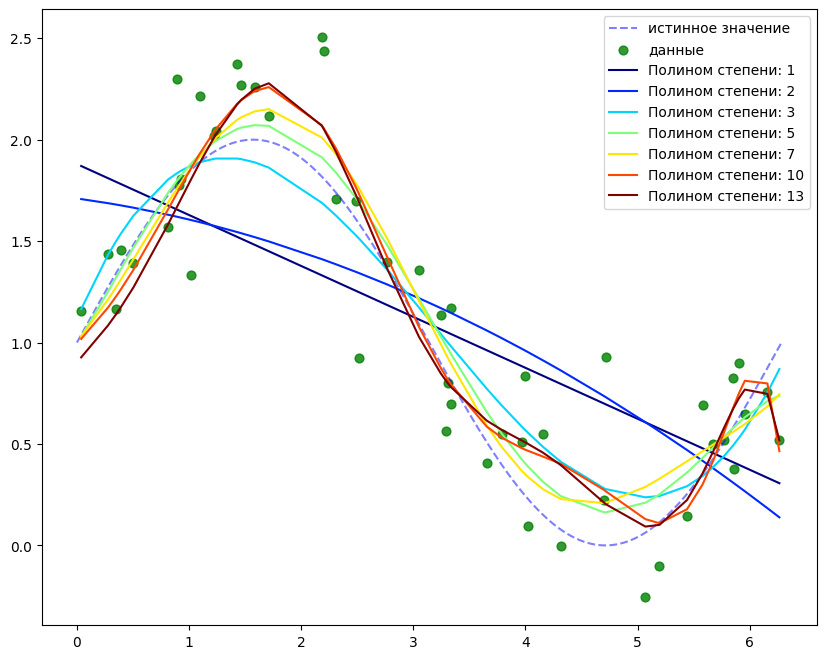

In [ ]:
# список степеней p полиномов, которые тестируются
degree_list = [1, 2, 3, 5, 7, 10, 13]

lmbd = 1 # коэффициент регуляризации

plt.figure(figsize=(10, 8)) # устанавливаем размер фигуры
cmap = plt.get_cmap('jet') # получаем цветовую палитру для линий
colors = [cmap(i) for i in np.linspace(0, 1, len(degree_list))] # задает набор разных цветов для линий

margin = 0.3
plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='истинное значение') # отображаем данные с параметрами
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='данные')

w_list = []
err = []
for ix, degree in enumerate(degree_list): # проходимся по полиномам и строим модель на новых данных
    # список с предрасчитанными степенями признака
    dlist = [np.ones(data['x_train'].shape[0])] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
    X = np.array(dlist).T
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + lmbd*np.eye(X.shape[1])), X.T), data['y_train'])
    y_hat = np.dot(w, X.T)
    err.append(np.mean((data['y_train'] - y_hat)**2))
    w_list.append((degree, w))
    print(f'Полином {degree} mse:', np.mean((data['y_train'] - y_hat)**2))
    plt.plot(data['x_train'], y_hat, color=colors[ix], label=f'Полином степени: {degree}')
    plt.legend()

Как видим, ситуация стала намного лучше. А что насчет дисперсии?

In [ ]:
def check_dispersion_l2(degree, lmbd=1):
    data = generate_data(1000)
    data = select_train_data(data, n_train=50, std=0.3)
    w_list = []
    err = []

    plt.figure(figsize=(10, 8)) # устанавливаем размер фигуры
    plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='истинное значение') # отображаем данные с параметрами

    for i in range(10): # проходимся по полиномам и строим модель на новых данных
        # список с предрасчитанными степенями признака
        dlist = [np.ones(data['x_train'].shape[0])] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
        X = np.array(dlist).T
        w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + lmbd*np.eye(X.shape[1])), X.T), data['y_train'])
        w_list.append(w)
        y_hat = np.dot(w, X.T)

        plt.plot(data['x_train'], y_hat, label=f'Exp: {i}')
        data = select_train_data(data, n_train=100, std=0.3)
    plt.legend()

    w_arr = np.array(w_list)
    stds = w_arr.std(axis=1)
    print(f"mean={stds.mean()}, std={stds.std()}")
    print(stds)

mean=0.2874900628007375, std=0.030275587873745086
[0.23505229 0.27526329 0.2540658  0.30168988 0.26198005 0.33559072
 0.32656584 0.2914933  0.30832008 0.28487937]


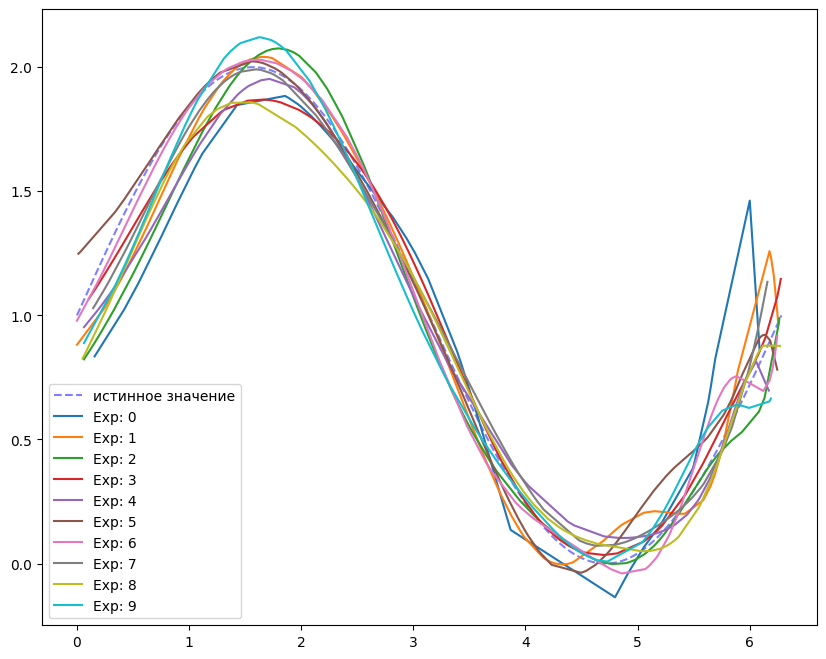

In [ ]:
check_dispersion_l2(degree=13)

Ситуация стала намного стабильнее!

## $L_1$-регуляризация

По аналогии ограничить вектор параметров можно и с помощью $L_1$ нормы:

$$\large R\left(\vec{w}\right) = \left\| \vec{w} \right\|_1 = \sum_{j=1}^m \left| w_j \right|$$

В таком случае функция потерь имеет вид:

$$\large \mathcal{L}\left(X, \vec{y}, \vec{w} \right) = \frac{1}{2n} \sum_{i=1}^n \left(\vec{x_i}^T \vec{w} - y_i\right)^2 + \lambda \sum_{j=1}^m \left| w_j \right|$$

Найдя производную по параметрам модели получим:
$$\large \frac{\partial \mathcal{L}}{\partial w_j} = \frac{1}{n}\sum_{i=1}^n \left(\vec{x_i}^T \vec{w} - y_i\right) \vec{x_i} + \lambda \text{sign}(\vec{w})$$

Задача не имеет решения в явном виде. Для поиска хорошего приближенного решения используем метод градиентного спуска.

$$\large \vec{w}_{\text{new}} := \vec{w} - \alpha \frac{\partial \mathcal{L}}{\partial \vec{w}}$$
где:

* $\large \alpha$ скорость градиентного спуска (learning rate)


Реализуем и ее на практике:

In [ ]:
lmbd = 1 # коэфф регулряизации
degree = 13 # полином 13 степени
dlist = [[1]*data['x_train'].shape[0]] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
X = np.array(dlist).T

# функция для вычисления среднеквадратичное ошибки
mse = lambda u, v: ((u - v)**2).sum()/u.shape[0]

# начальное приближение размером с пространство признаком
w = np.array([-1.0] * X.shape[1])
# максимальное количество итераций
n_iter = 20
# сделаем скорость обучения очень маленькой, на всякий случай
lr = 0.0000000001
loss = []
for ix in range(n_iter): # ограничение на количество итераций
    w -= lr*(np.dot(np.dot(X, w) - data['y_train'], X)/X.shape[0] + lmbd*np.sign(w))
    y_hat = np.dot(X, w)
    loss.append(mse(data['y_train'], y_hat))
    print(loss[-1])

3.611657083251923e+38
3.1600264876353024e+57
2.7648714073281177e+76
2.4191296905175872e+95
2.1166222935478525e+114
1.8519428499863645e+133
1.620361048860925e+152
1.4177380952576425e+171
1.2404527424043776e+190
1.0853365732962917e+209
9.496173752264824e+227
8.308695952198913e+246
7.269709909174942e+265
6.360647021819333e+284
5.565260655740635e+303
inf
inf
inf
inf
inf


<ipython-input-16-3b291581f92b>:7: RuntimeWarning: overflow encountered in square
  mse = lambda u, v: ((u - v)**2).sum()/u.shape[0]


В результате функция потерь взрывается и уходит на бесконечность. Причина в разных масштабах - от небольших чисел у полиномиальных признаков 1-2 степени, до огромных при 12-13 степени. Градиентный спуск чувствителен к настолько большим разницам в масштабах :(

Есть два способа борьбы заставить итеративный процесс сойтись:
- выбрать экстремально малую скорость обучения
- нормализовать признаки - например, привести признаки к единичному матожиданию и единичной дисперсии

$$\large \begin{array}{rcl} \overline{\mu}_{\cdot j} &=& \frac{1}{n} \sum_{i=1}^n x_{ij} \\
\overline{\sigma}_{\cdot j} &=& \sqrt{\frac{1}{n} \sum_{i=1}^n \left( x_{ij} - \overline{\mu}_{\cdot j} \right)}
\end{array}$$
где $j$ - номер признака, $i$ - точки данных.

Тогда новый призак:
$$\large \vec{x}_{\text{new}} = \frac{\vec{x} - \overline{\mu}}{\overline{\sigma}}$$

Попробуем обучиться с $L_1$-регуляризацией и с масштабированными признаками:

<ipython-input-17-cfb9995185ad>:11: RuntimeWarning: invalid value encountered in divide
  X = (X - x_mean) / x_std


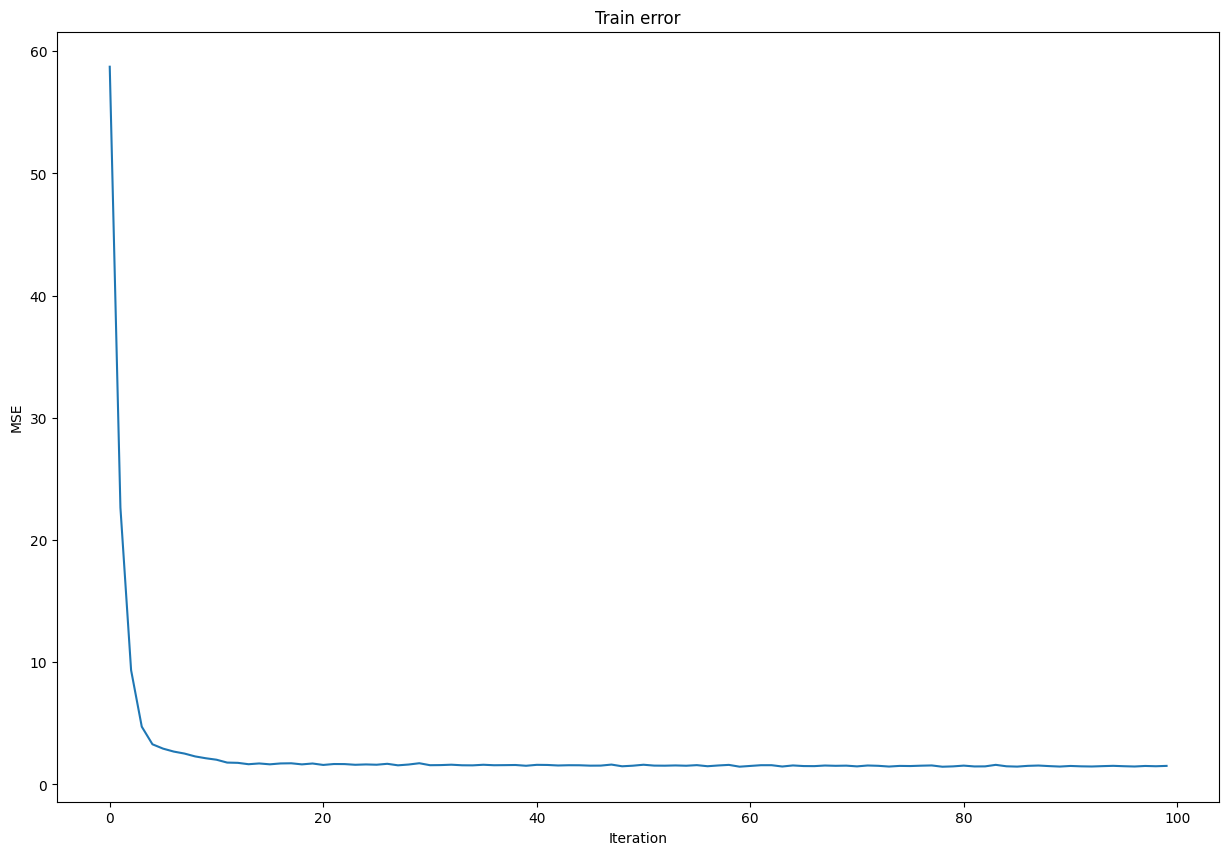

In [ ]:
lmbd = 1 # коэфф регуляризации
degree = 13 # полином 13 степени
dlist = [[1]*data['x_train'].shape[0]] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
X = np.array(dlist).T

# вычислим выборочное среднее каждого признака
x_mean = X.mean(axis=0)
# вычислим выборочное стандартное отклонение признаков
x_std = X.std(axis=0)
# применим преобразование
X = (X - x_mean) / x_std
X[:, 0] = 1.0 # добавим столбец смещений

# функция для вычисления среднеквадратичное ошибки
mse = lambda u, v: ((u - v)**2).sum()/u.shape[0]

# начальное приближение размером с пространство признаком
w = np.array([-1.0] * X.shape[1])
# максимальное количество итераций
n_iter = 100
# сделаем скорость обучения очень маленькой, на всякий случай
lr = 0.03 # часто устанавливают с этой константой для небольших моделей
loss = []
for ix in range(n_iter): # ограничение на количество итераций
    w -= lr*(np.dot(np.dot(X, w) - data['y_train'], X)/X.shape[0] + lmbd*np.sign(w))
    y_hat = np.dot(X, w)
    loss.append(mse(data['y_train'], y_hat))

plt.figure(figsize=(15, 10))
plt.plot(loss)
plt.title('Train error')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

Как видим, обучение выполнилось штатно. Попробуем отобразить выучиваемые полиномиальные зависимости:

<ipython-input-18-8a69bea82ddd>:11: RuntimeWarning: invalid value encountered in divide
  X = (X - x_mean)/x_std
<ipython-input-18-8a69bea82ddd>:38: RuntimeWarning: invalid value encountered in divide
  X = (X - x_mean)/x_std


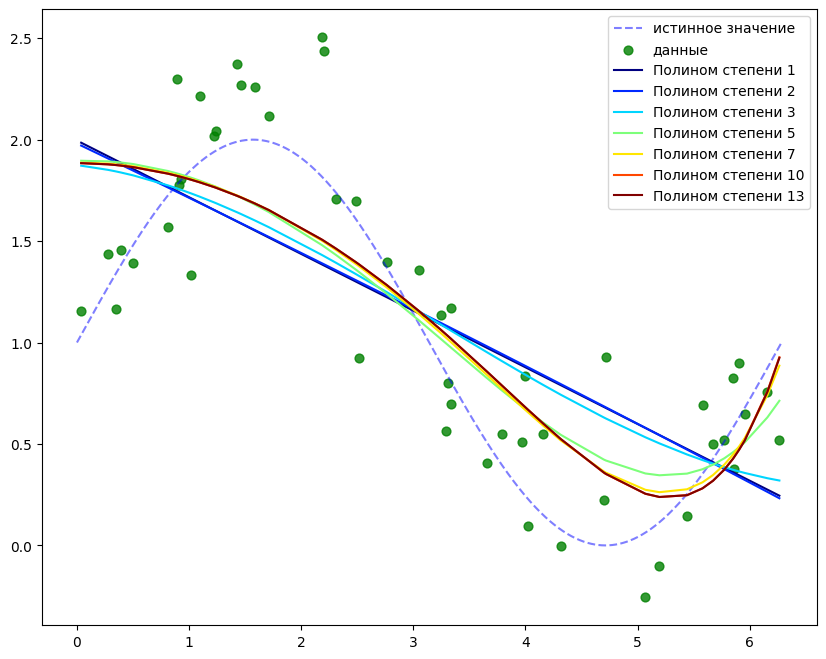

In [ ]:
lmbd = 1000 # коэфф регулряизации
degree = 15 # полином 13 степени
dlist = [[1]*data['x_train'].shape[0]] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
X = np.array(dlist).T

# вычислим выборочное среднее каждого признака
x_mean = X.mean(axis=0)
# вычислим выборочное стандартное отклонение признаков
x_std = X.std(axis=0)
# применим преобразование
X = (X - x_mean)/x_std
X[:, 0] = 1.0 # добавим столбец смещений

margin = 0.3
plt.figure(figsize = (10, 8))
plt.plot(data['support'], data['values'], 'b--', alpha=0.5, label='истинное значение')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='данные')

# функция для вычисления среднеквадратичное ошибки
mse = lambda u, v: ((u - v)**2).sum()/u.shape[0]

def fit_lr_l1(X, y, lmbd, n_iter=10000, lr=0.1):
    w = np.array([-1.0] * X.shape[1])
    loss = []
    for ix_iter in range(n_iter):
        w -= lr*(np.dot(np.dot(X, w) - y, X)/X.shape[0] +lmbd*np.sign(w))
        y_hat = np.dot(X, w)
        loss.append(mse(y, y_hat))
    return w, y_hat, loss


w_list_l1 = []
for ix, degree in enumerate(degree_list):
    dlist = [[1]*data['x_train'].shape[0]] + list(map(lambda n: data['x_train']**n, range(1, degree + 1)))
    X = np.array(dlist).T
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)
    X = (X - x_mean)/x_std
    X[:, 0] = 1.0
    w, y_hat, loss = fit_lr_l1(X, data['y_train'], lmbd=0.01)
    w_list_l1.append((degree, w))
    # print(f'Полином {degree} loss {loss[-1]}')
    plt.plot(data['x_train'], y_hat, color=colors[ix], label=f'Полином степени {degree}')
plt.legend()

Видим излишнюю "линейность" в полученных зависимостях. Что поменялось по сравнению с $L_2$?

Посмотрим на амплитуды коэффициентов:

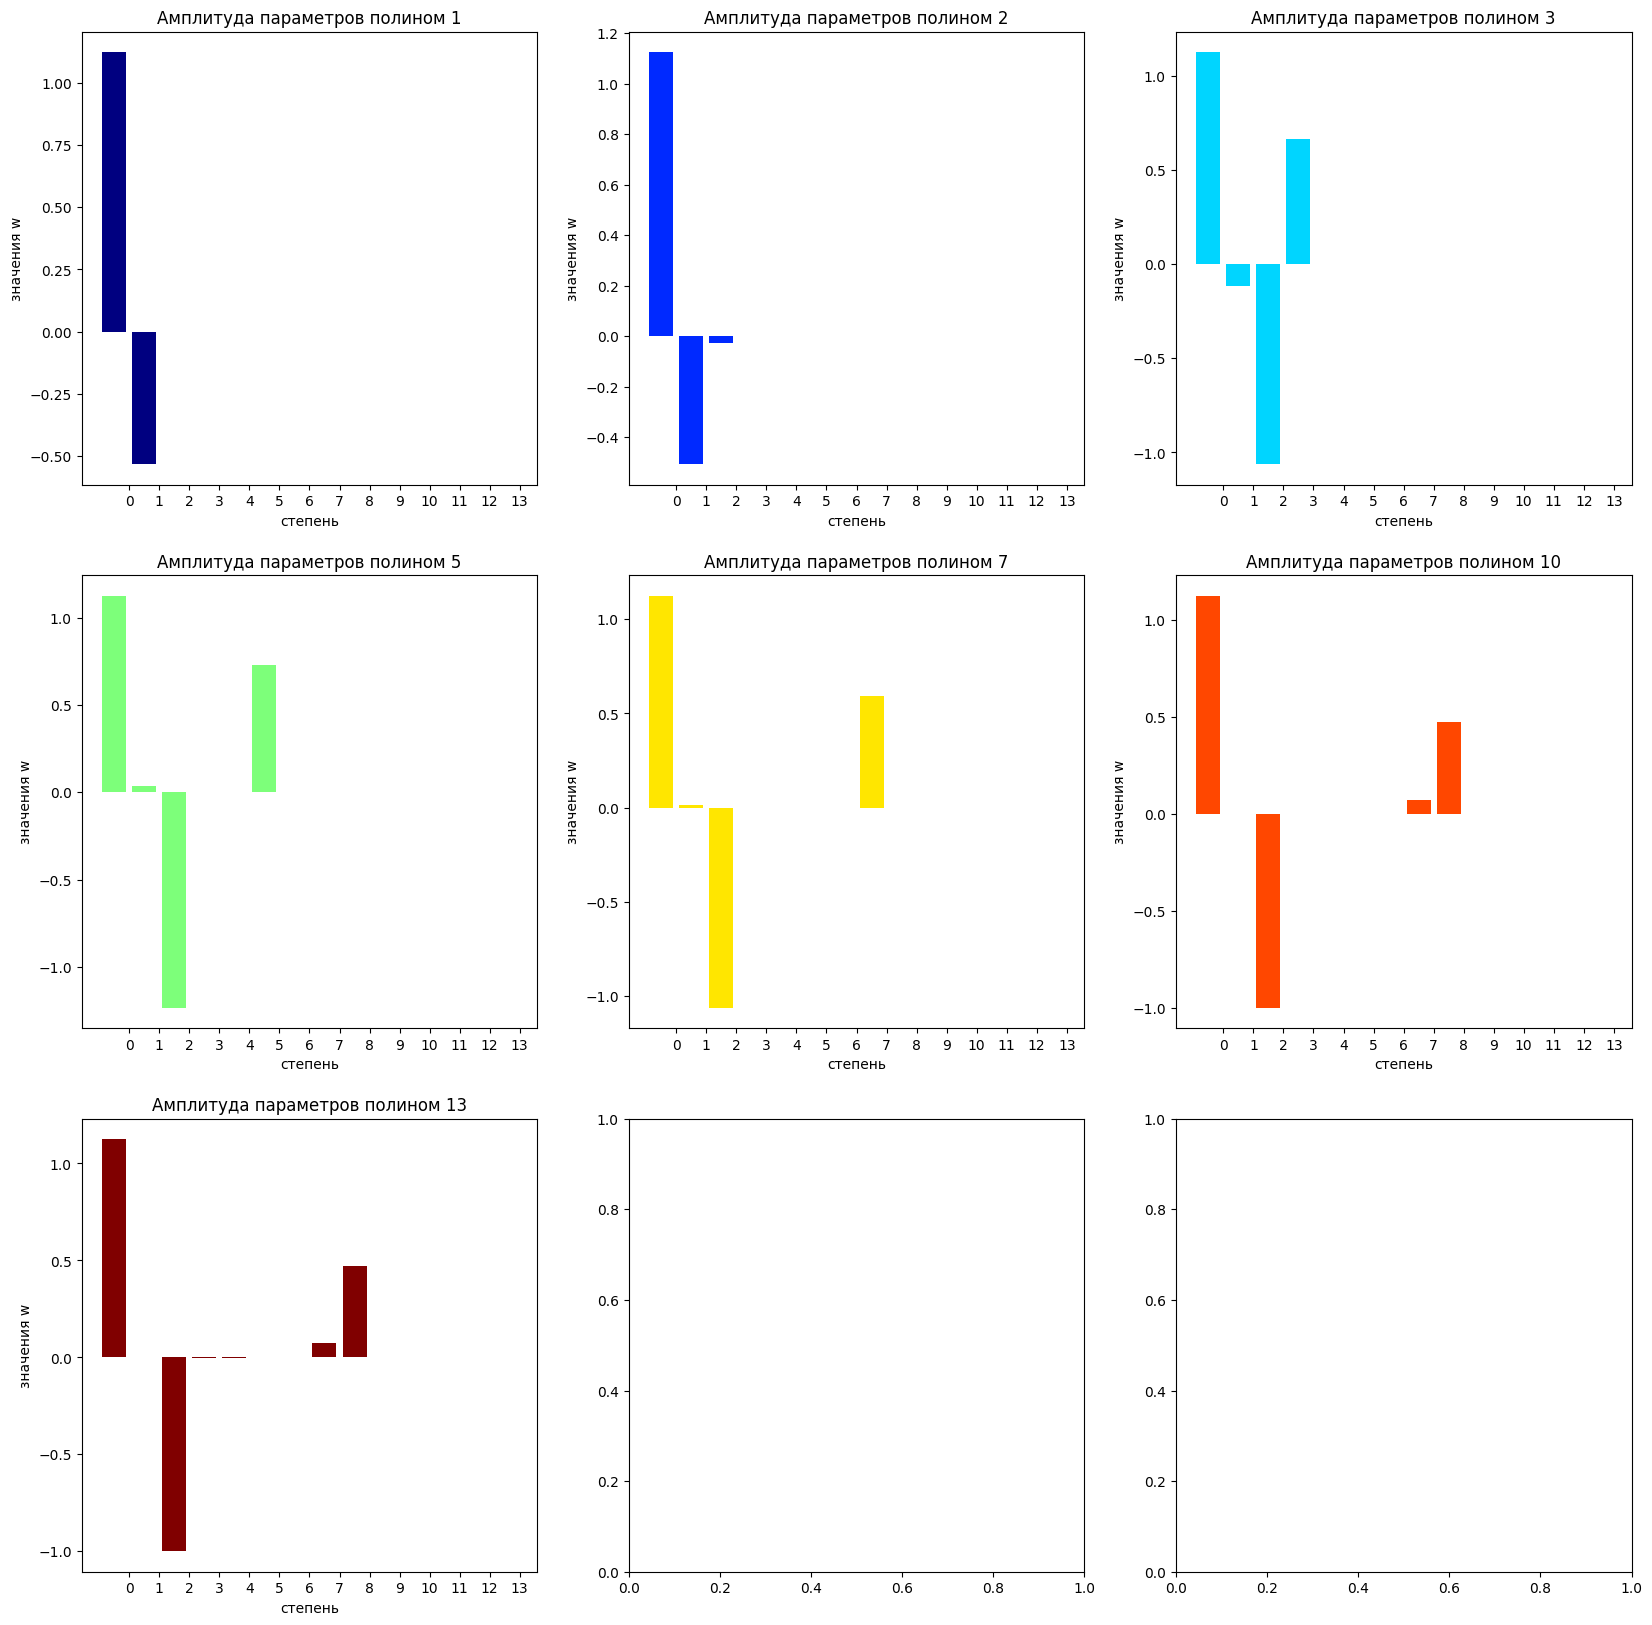

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(20, 20))

for ix, t, ax in zip(range(len(w_list_l1)), w_list_l1, axes.flatten()):
    degree, w = t
    ax.bar(range(max(degree_list) + 1), np.hstack((w, [0]*(max(degree_list) - w.shape[0] + 1))), color=colors[ix])
    ax.set_title('Амплитуда параметров полином ' + str(degree))
    ax.set_xlabel('степень')
    ax.set_ylabel('значения w')
    ax.set_xticks(np.array(range(max(degree_list) + 1)) + 0.5)
    ax.set_xticklabels(range(max(degree_list) + 1))
plt.show()

Наблюдаем большое количество нулевых амплитуд!

Этот факт является отличительным свойством $L_1$-регуляризации:

>Применение $L_1$-регуляризации приводит к тому, что у признаков, которые не оказывают большого влияния на ответ, вес в результате оптимизации получается равным нулю.

>**Note:**
>
>Описанный способ построения регрессии ($L_1$) называется LASSO регрессия.
>
>`LASSO = least absolute shrinkage and selection operator`.

Схематичное сравнение регуляризаций:

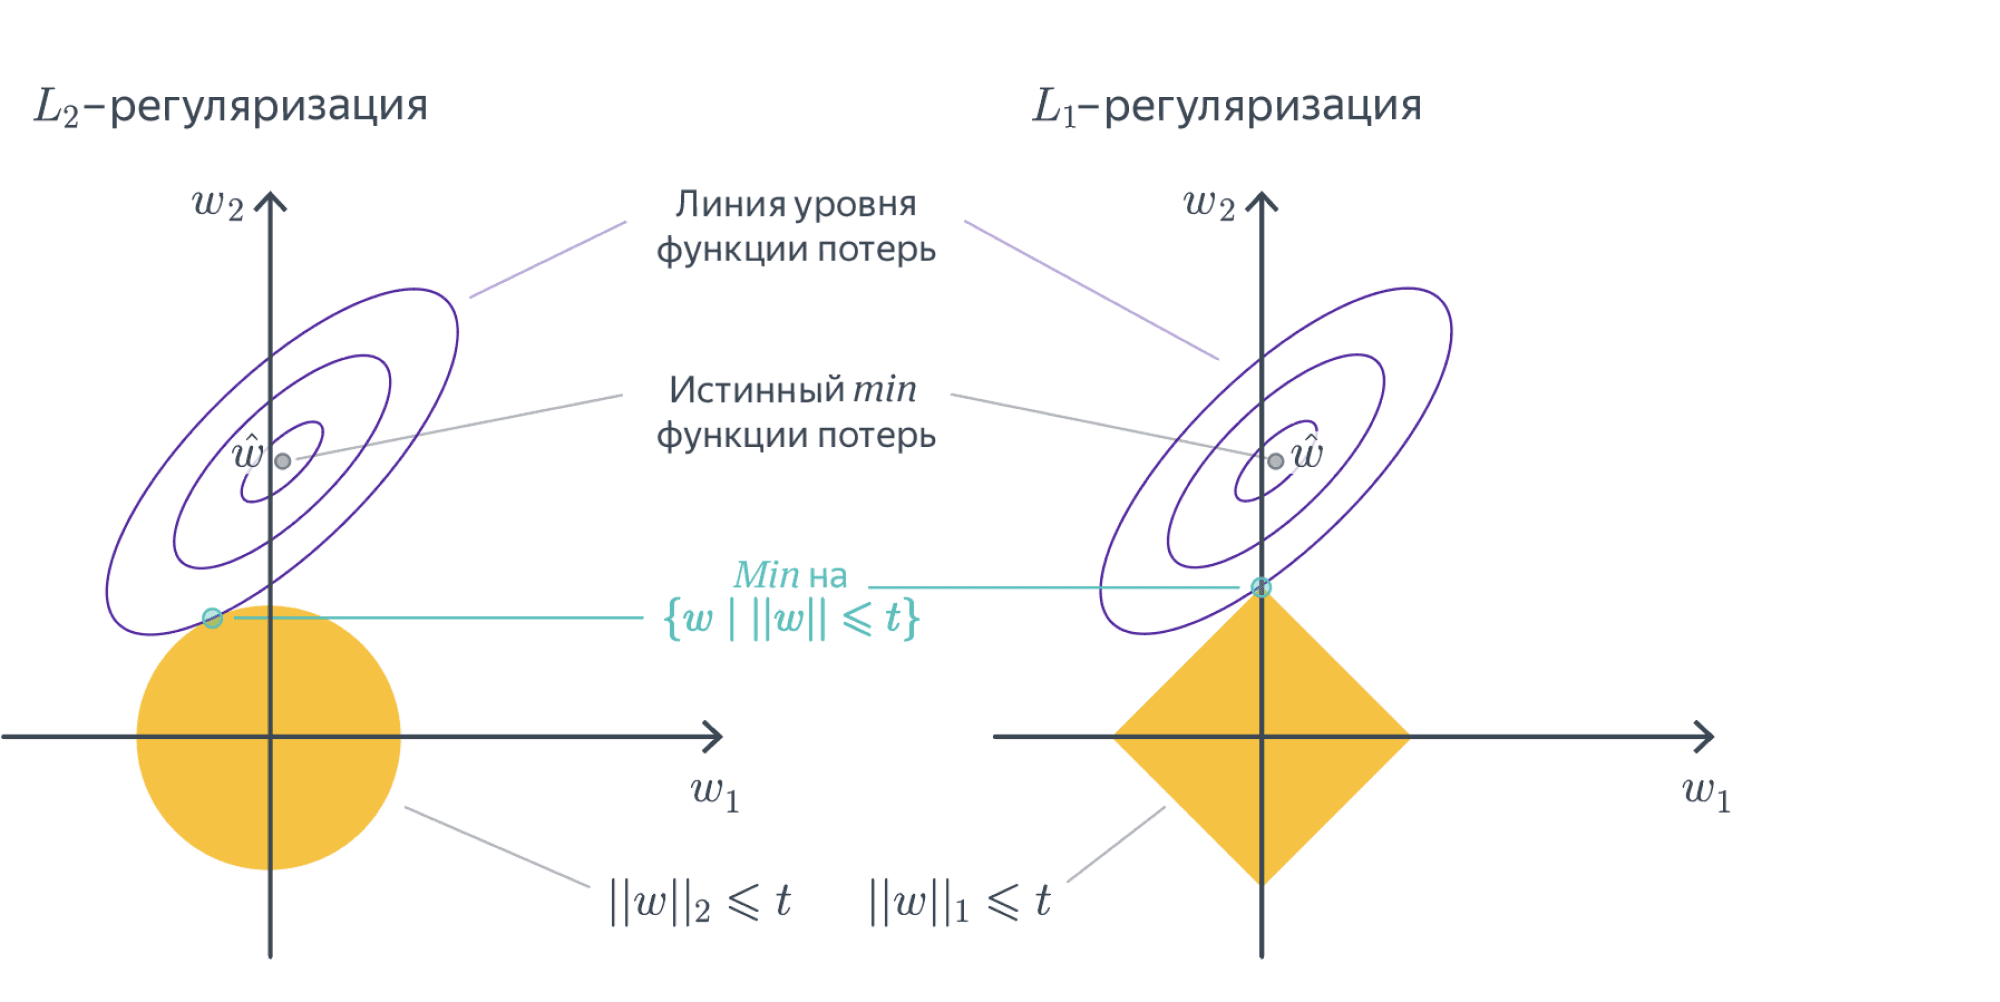

# Выбор параметров

Теперь для нахождения оптимального решения мы должны подбирать не только веса $w$, но и коэффициент регуляризации $\lambda$. Более того, мы не можем их подбирать одновременно - параметры модели подбираются алгоритмом, гиперпараметры подбираются нами.

До текущего момента наш процесс обучения выглядел следующим образом:
1. Разбиваем данные на 2 части - обучающая и валидационная
2. Фиксируем некоторое значение гиперпараметров
3. Обучаем модель на обучающей выборке
4. Получаем метрики на валидационной
5. Меняем гиперпараметры так, чтобы метрика на валидации стала лучше
6. Повторяем шаги 3-5

Что здесь может пойти не так? Почему мы изначально разбили данные на 2 части?

2 части, чтобы не получили завышенную оценку, т.к. наша модель обучается решать задачу на конкретной обучающей выборке, а мы хотим чтобы могла решать задачу на любой другой, но схожей обучающей выборке. 2я часть - проверка того, как алгоритм работает на совсем новых данных.

Когда мы подбираем гиперпараметры, то мы по сути так же стараемся улучшить значение метрики на конкретном наборе данных. Значит тоже по сути получаем завышенные значения. А хотим проверить как модель с подобранными значениями гиперпараметров будет обучаться на новых данных.

Поэтому обычно разделяют набор данных на три подмножества (или вариации):

- **обучающий** - для поиска параметров модели
- **валидационный** - для подбора гиперпараметров
- **тестовый** (hold out) - для окончательного тестирования модели


Проверим наши навыки на датасете цен на жилье в Бостоне ([все датасеты sklearn](https://scikit-learn.org/stable/datasets/toy_dataset.html)):

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets

# загрузим данные
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
print('Форма набора:', data.shape)

ix_test = np.random.choice(range(data.shape[0]), size=200, replace=False)
ix_train = np.setdiff1d(range(data.shape[0]), ix_test)
ix_cols = np.array([0, 2, 4, 5, 6, 7, 10, 11, 12])

# разделим на треин тест
x_train = data[ix_train, :][:, ix_cols]
x_test = data[ix_test, :][:, ix_cols]
y_train = target[ix_train]
y_test = target[ix_test]

Форма набора: (506, 13)


Для дальнейшего эксперимента будет использована модель эластичной сети (ElasticNet) из пространства линейных моделей, в которой используется выпуклая комбинация L1 и L2 регуляризации, формула для Loss:

$$\displaystyle\min\limits_{w}\frac{1}{2n_{samples}}\lVert X_{w}-Y\rVert_2^2+\alpha\rho\lVert W\rVert_1+\frac{\alpha\lgroup 1-\rho\rgroup}{2}\ \lVert W\rVert_2^2$$

где $\alpha$ - коэффициент регуляризации alpha в api sklearn. $\rho$- коэффициент l1 регуляризации l1_ratio в api sklearn.


Воспроизведем с помощью Sklearn предобработку и обучим модель:

In [ ]:
from sklearn.linear_model import ElasticNet # elastic
from sklearn.metrics import mean_squared_error # mse
from sklearn.preprocessing import StandardScaler # стандартизация
from sklearn.preprocessing import PolynomialFeatures # полиномиальные признаки

# степень полинома в генерации признаков
degree = 2
# гиперпараметры ElasticNet
# коэффициент регуляризации эластикнет l2
alpha = 0.01
# коэффициент регуляризации l1
l1_ratio = 0.5

# создаем объект для генерации полиномиальных признаков
pf = PolynomialFeatures(degree=degree, include_bias=False)
# создаем объект sklearn для стандартизации данных
ss = StandardScaler()

# применяем трансформацию к train
X_train = ss.fit_transform(pf.fit_transform(x_train))
print('Форма X_train после добавления полиномиальных признаков:', X_train.shape)
# применяем трансформацию к test
X_test = ss.transform(pf.transform(x_test))

# создаем линейную модель эластикнет с l1 и l2 регуляризациями
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
model = model.fit(X_train, y_train)

# получаем предсказания на треин и тест
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

# смотрим на материки train и test
print('Train mse : ', mean_squared_error(y_train, y_hat_train))
print('Test mse  : ', mean_squared_error(y_test, y_hat_test))

Форма X_train после добавления полиномиальных признаков: (306, 54)
Train mse :  10.812160593875086
Test mse  :  16.410564409634834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+03, tolerance: 2.600e+00
  model = cd_fast.enet_coordinate_descent(


Воспользуемся кросс-валидацией ([k-fold cross-valdation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)) для оценки ошибки на тестовом множестве. Пример 5-folds:

![](https://www.researchgate.net/profile/Mariia-Fedotenkova/publication/311668395/figure/fig5/AS:613923871019041@1523382265447/A-schematic-illustration-of-K-fold-cross-validation-for-K-5-Original-dataset-shown.png)

Значения метрик на валидации усредняются для более стабильных оценок.

In [ ]:
# кросс-валидация
from sklearn.model_selection import KFold

# создадим кросс-валидацию на 5 фолдах, будем перемешивать для большего разнообрация
kf = KFold(n_splits=5, shuffle=True)

mse_train_folds = []
mse_valid_folds = []
# итерируемся по сплитам
for ix_train, ix_valid in kf.split(X_train):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
    model = model.fit(X_train[ix_train, :], y_train[ix_train])
    # записываем MSE на train
    mse_train_folds.append(
        mean_squared_error(
            y_train[ix_train],
            model.predict(X_train[ix_train, :])))
    # записываем MSE на valid
    mse_valid_folds.append(
        mean_squared_error(
            y_train[ix_valid],
            model.predict(X_train[ix_valid, :])))

# смотрим среднее значение на train val
mse_train_folds = np.mean(mse_train_folds)
mse_valid_folds = np.mean(mse_valid_folds)

# тренируем модель на всем наборе
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
model = model.fit(X_train, y_train)
# создаем предсказания
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

print('Train mse cross-val:', mse_train_folds)
print('Train mse:', mean_squared_error(y_train, y_hat_train))
print('Valid mse:', mse_valid_folds)
print('Test mse:', mean_squared_error(y_test, y_hat_test))

Train mse cross-val: 10.312826090048025
Train mse: 10.812160593875086
Valid mse: 15.33350080590427
Test mse: 16.410564409634834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.874e+02, tolerance: 2.067e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.183e+02, tolerance: 2.004e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.336e+02, tolerance: 2.061e

Видно, что ошибка на валирационном множестве является значительно более точной оценкой ошибки на тестовом множестве. Это дает нам возможность сравнивать различные модели не прибегая к использованию тестового множества. Ошибка в дизайне такого эксперимента критична и может стоить всего эксперимента, если допущена в самом начале.

Воспользуемся этой техникой, чтобы найти оптимальную степень полиномиальной регрессии в эластичной сети.

  0%|          | 0/6 [00:00<?, ?it/s]

лучший рез на тесте: 14.641696189004625


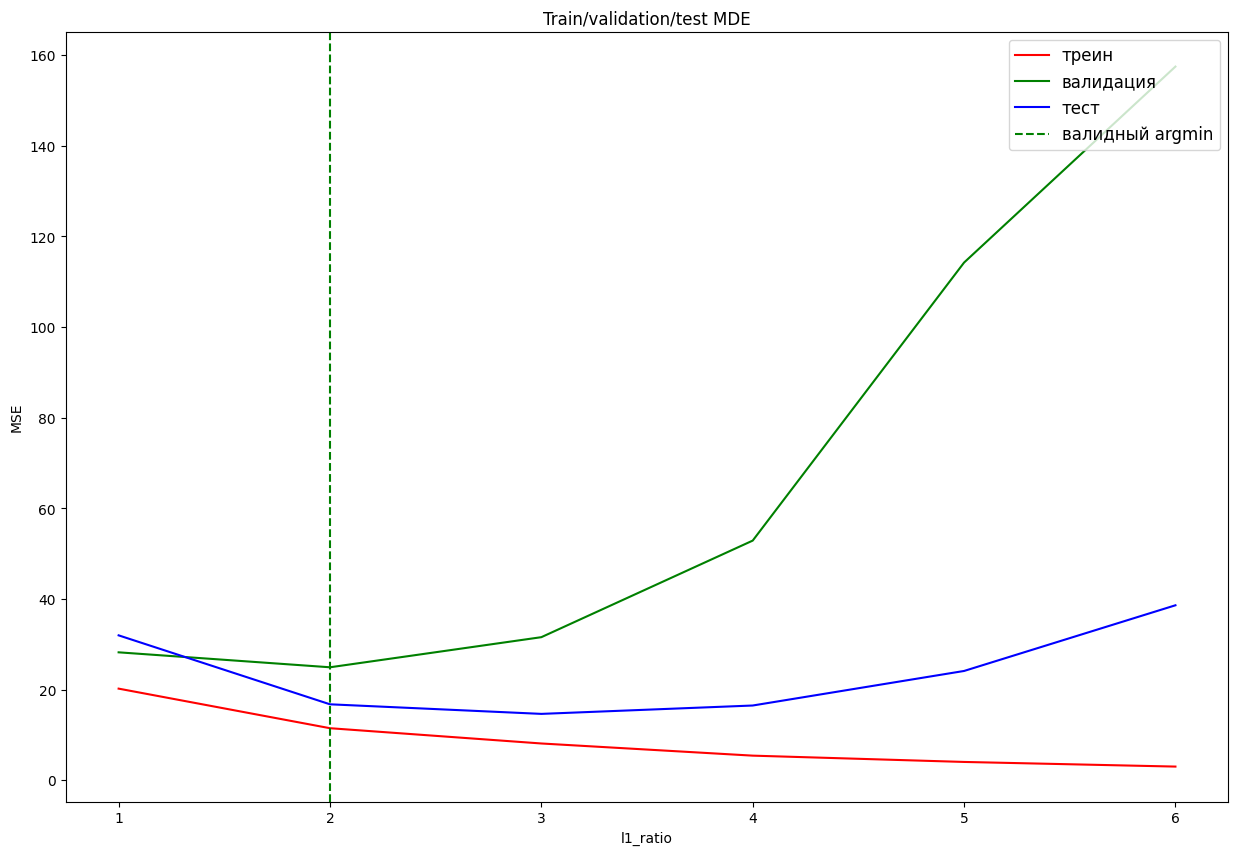

In [ ]:
# прогресс бар
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

l1_ratio = 0.01

kf = KFold(n_splits=5, shuffle=False)

mse_train = []
mse_valid = []
mse_test = []
# итерируемся по параметрам степени полинома
degree_list = range(1, 7)
for degree in tqdm_notebook(degree_list):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    ss = StandardScaler()
    X_train = ss.fit_transform(pf.fit_transform(x_train))
    X_test = ss.transform(pf.transform(x_test))

    mse_valid_folds = []
    for ix_train, ix_valid in kf.split(X_train):
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
        model = model.fit(X_train[ix_train, :], y_train[ix_train])
        mse_valid_folds.append(
            mean_squared_error(
                y_train[ix_valid],
                model.predict(X_train[ix_valid, :])))
    mse_valid.append(np.mean(mse_valid_folds))
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
    model = model.fit(X_train, y_train)
    mse_train.append(mean_squared_error(y_train, model.predict(X_train)))
    mse_test.append(mean_squared_error(y_test, model.predict(X_test)))


print('лучший рез на тесте:', np.min(mse_test))
plt.figure(figsize=(15, 10))
plt.plot(degree_list, mse_train, c='r', label='треин')
plt.plot(degree_list, np.array(mse_valid), c='g', label='валидация')
plt.plot(degree_list, mse_test, c='b', label='тест')

x = sorted(zip(degree_list, mse_valid), key=lambda t: t[1])[0][0]
plt.axvline(x, color='g', linestyle='--', label='валидный argmin')


plt.legend(loc='upper right', prop={'size': 12})
plt.title('Train/validation/test MDE', fontsize=12)
plt.xlabel('degree_list')
plt.ylabel('MSE')
plt.show()


Но руками перебирать гиперпараметры неудобно, благо есть готовые инструменты:

## Grid Search

Самый естественный способ организовать перебор наборов гиперпараметров — сделать перебор по сетке (**Grid Search**):

1. для каждого гиперпараметра фиксируется несколько значений;
2. перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
3. выбирается комбинация, на которой модель показывает лучшее качество.

Перебор некоторых значений гиперпараметров можно вести по логарифмической шкале - позволяет быстрее определить порядок параметра. Так можно подбирать, например, значение `learning rate` для градиентного спуска или значение константы регуляризации для линейной регрессии.

>Сразу же видно естественное ограничение данного метода:
>
>если комбинаций параметров слишком много либо каждое обучение / тест длится долго, алгоритм не завершится за разумное время.

## Random Search

Если у вас возникает очень большое количество комбинаций параметров, вы можете какими-то способами пытаться справляться с этой проблемой:

- можно взять меньше значений каждого гиперпараметра, но тогда есть шансы пропустить наилучшую комбинацию;
- можно уменьшить число фолдов в кросс-валидации, но оценка параметров станет более шумной;
- можно оптимизировать параметры последовательно, а не перебирать их комбинации, но снова есть шанс получить неоптимальное решение;
- можно перебирать не все комбинации гиперпараметров, а только **случайное подмножество**.

Последний способ называется `Random Search`. Для каждого гиперпараметра задаётся распределение, из которого выбирается его значение, и комбинация гиперпараметров составляется семплированием из этих распределений.

Таким образом из-за случайного выбора комбинации гиперпараметров можем найти оптимальную комбинацию за меньшее число итераций.

Вот эта картиночка хорошо иллюстрирует отличия поиска по сетке от случайного поиска:

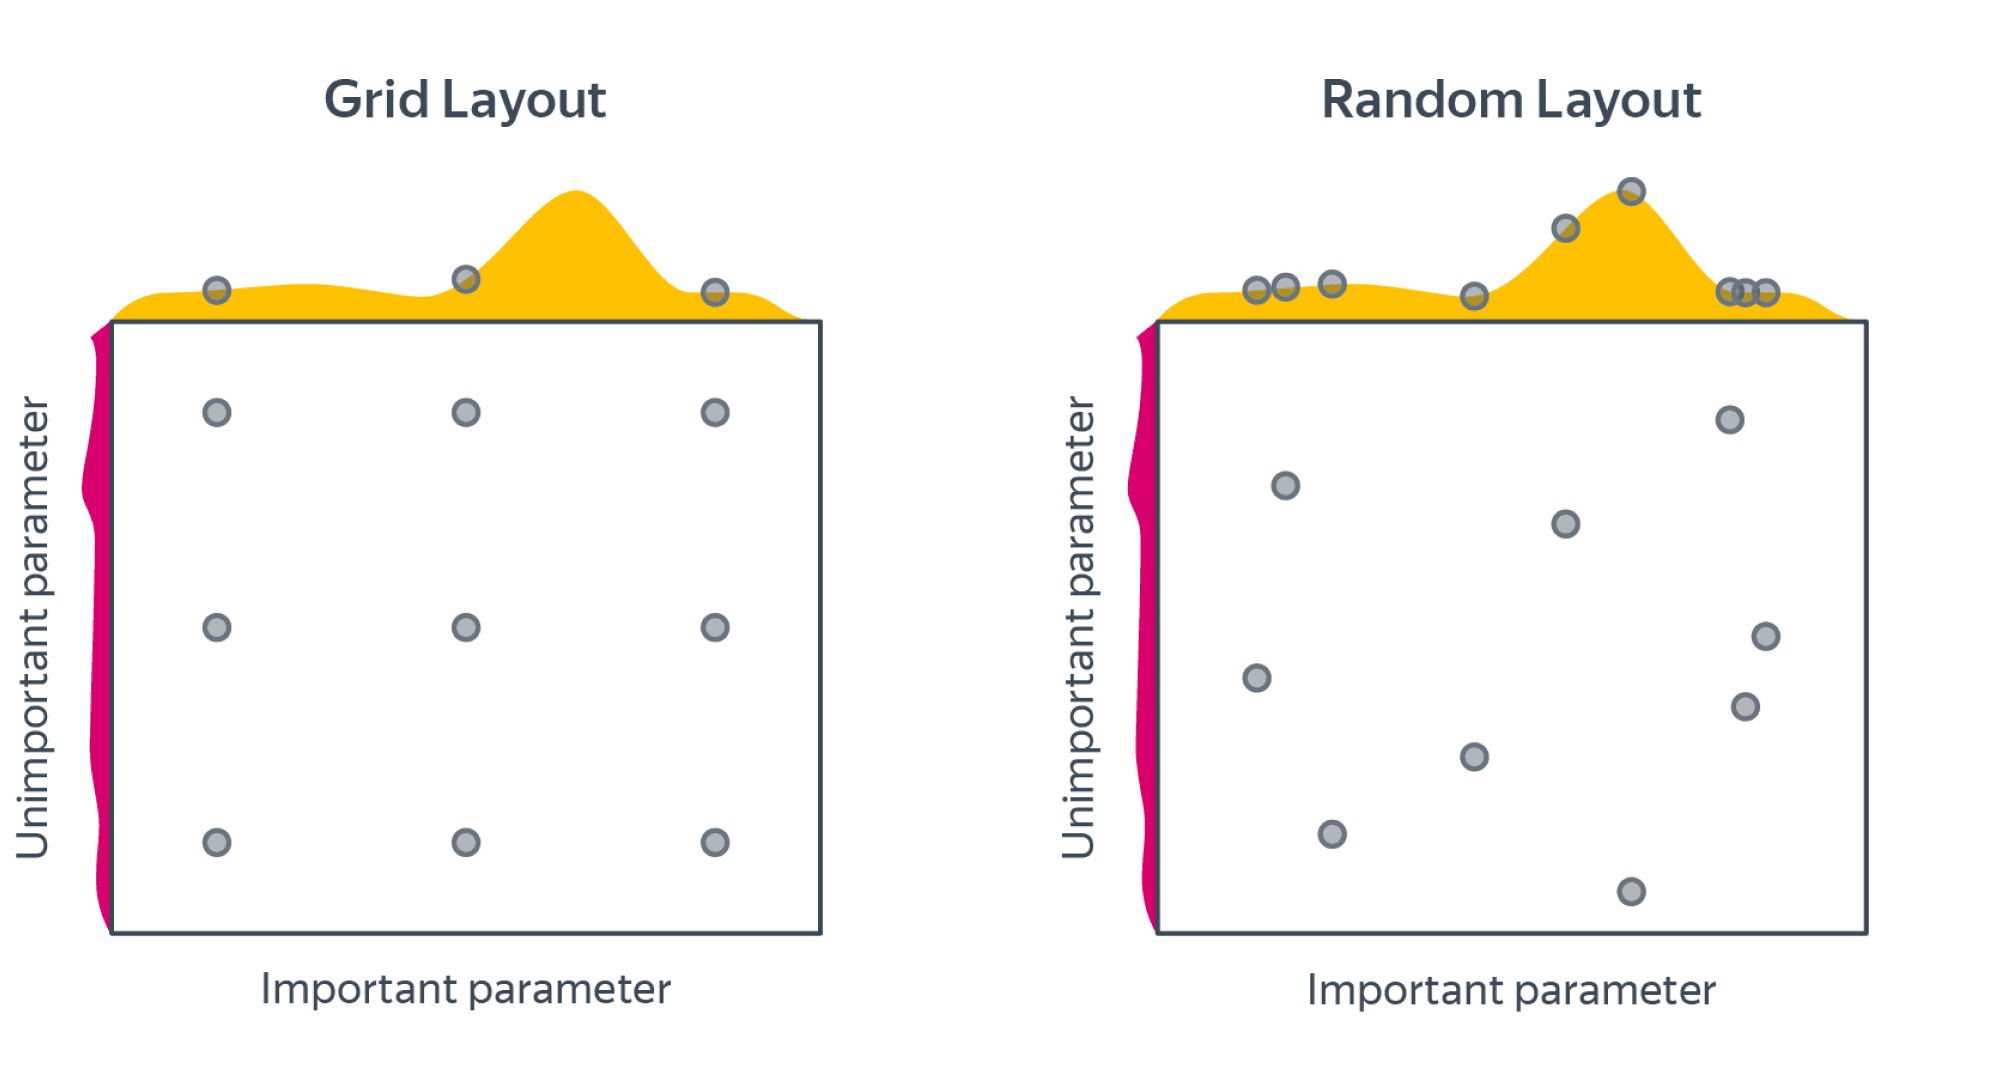

## Exploration vs exploitation

Проще объяснить эти термины на примере:

>Перед вами стоит выбор, в какой ресторан пойти сегодня.
>
>Ваш любимый ресторан - прямо за углом. Вы ходите туда каждый день и поэтому достаточно уверены в том, насколько вкусным будет ваш обед.
>
>Но при этом не рассматриваете никакие другие опции и, возможно, упускаете возможность поесть гораздо вкуснее в другом месте. Если же вы будете обедать каждый раз в новом месте, то очень часто будете не удовлетворены результатом.

Любой метод подбора гиперпараметров ищет баланс между `exploration` и `exploitation`.

Одно из основных отличий более продвинутых методов от Grid Search и Random Search — возможность учитывать результаты предыдущих вычислений.

Есть две опции:
- `exploration` - исследование тех областей, в которых у нас мало семплов на текущей итерации - сложнее пропустить оптимальное значение
- `exploitation` - выбирать больше семплов в областях, которые мы достаточно неплохо изучили и где, как мы считаем, с большой вероятностью находится оптимум

Более продвинутые алгоритмы:
- Байесовская оптимизация
- Tree-structured Parzen Estimator
- Population Based Training

## Имплементация

Для поиска в параметров в большем пространстве параметров существует несколько вспомогательных классов:

* [Pipeline](http://scikit-learn.org/stable/modules/pipeline.html), который позволяет объединять несколько трансформеров данных и моделей в одну модель; например полиномиальная трансформация, стандардизация, обучение модели; новая модель обладает интерфейсом модели, т.е. реализует функции `fit` и `predict` (`predict_proba`);
* [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) сделан для поиска оптимальных параметров (полный перебор в ограниченном пространстве гипотез); этот класс также реализует интерфейс модели; финальная модель может быть обучена на всем тренировочном множестве, используя найденные оптимальные параметры.


In [ ]:
from sklearn.pipeline import Pipeline # конвейер обработки
# конвейерз из 3 шагов
pipe = Pipeline(steps=[
    ('pf', PolynomialFeatures(include_bias=False)),
    ('ss', StandardScaler()),
    ('en', ElasticNet())
])
pipe.named_steps

{'pf': PolynomialFeatures(include_bias=False),
 'ss': StandardScaler(),
 'en': ElasticNet()}

Переберем обозначенные параметры с помощью грид-серча:

In [ ]:
parameters = {
    'pf__degree': [1, 2, 3],
    'en__alpha': [0.001, 0.01, 0.02, 0.1, 0.5],
    'en__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 1]
}

for k, v in parameters.items():
    print(k, v)

pf__degree [1, 2, 3]
en__alpha [0.001, 0.01, 0.02, 0.1, 0.5]
en__l1_ratio [0.001, 0.01, 0.1, 0.5, 0.9, 1]


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# перебираем набор, параметров, кросс-вал по 10 фолдам, нджобс паралелит на все ядра процессора доступные, вебоуз - отображает ход
grid_search = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1, verbose=1)
grid_search = grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [ ]:
print('Лучшие прамметры:', grid_search.best_params_)
print('Тестовый результат:', mean_squared_error(y_test, grid_search.predict(x_test)))

Лучшие прамметры: {'en__alpha': 0.5, 'en__l1_ratio': 0.9, 'pf__degree': 3}
Тестовый результат: 21.066605616604804
